In [2]:
# load a coffea file
from coffea.util import load
import os
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib
from sklearn.metrics import roc_auc_score, roc_curve

# cms
hep.style.use("CMS")

matplotlib.rcParams["figure.dpi"] = 300

In [3]:
input = "/pnfs/psi.ch/cms/trivcat/store/user/tharte/datasets/sample_spanet/DATA_loose_cut/output_all.coffea"

o = load(f"{input}")
sample=list(o["columns"].keys())[0]
dataset=list(o["columns"][sample].keys())[0]
print(f"sample: {sample}, dataset: {dataset}")
categories = list(o["columns"][sample][dataset].keys())
print(f"categories: {categories}")
col_2b=o["columns"][sample][dataset]["2b_region"]
col_4b=o["columns"][sample][dataset]["4b_region"]





sample: DATA_JetMET_JMENano_skimmed, dataset: DATA_JetMET_JMENano_2022_postEE_EraE
categories: ['4b_region', '2b_region']


In [4]:
for k in col_2b.keys():
    print(k)
    col_2b[k]=col_2b[k].value#[col[k].value!=-999]
    col_4b[k]=col_4b[k].value#[col[k].value!=-999]


JetGoodHiggsMatched_N
JetGoodHiggsMatched_provenance
JetGoodHiggsMatched_pt
JetGoodHiggsMatched_eta
JetGoodHiggsMatched_phi
JetGoodHiggsMatched_mass
JetGoodHiggsMatched_btagPNetB
JetGoodMatched_N
JetGoodMatched_provenance
JetGoodMatched_pt
JetGoodMatched_eta
JetGoodMatched_phi
JetGoodMatched_mass
JetGoodMatched_btagPNetB
JetGoodHiggs_N
JetGoodHiggs_provenance
JetGoodHiggs_pt
JetGoodHiggs_eta
JetGoodHiggs_phi
JetGoodHiggs_mass
JetGoodHiggs_btagPNetB
JetGood_N
JetGood_provenance
JetGood_pt
JetGood_eta
JetGood_phi
JetGood_mass
JetGood_btagPNetB


In [5]:

jet_btag_2b = ak.unflatten(col_2b["JetGoodMatched_btagPNetB"], col_2b["JetGoodMatched_N"])
jet_btag_3_2b=jet_btag_2b[:, 2]
jet_btag_4_2b=jet_btag_2b[:, 3]
jet_btag_1_2b=jet_btag_2b[:, 0]

jet_btag_4b = ak.unflatten(col_4b["JetGoodMatched_btagPNetB"], col_4b["JetGoodMatched_N"])
jet_btag_3_4b=jet_btag_4b[:, 2]
jet_btag_4_4b=jet_btag_4b[:, 3]

print(f"2b: {jet_btag_3_2b} {jet_btag_4_2b}")
print(f"4b: {jet_btag_3_4b} {jet_btag_4_4b}")


2b: [0.0135, 0.0331, 0.00816, 0.0195, 0.00744, ... 0.0177, 0.102, 0.0259, 0.167, 0.207] [0.00554, 0.0074, 0.0047, 0.0139, 0.00515, ... 0.013, 0.0116, 0.0448, 0.00491]
4b: [0.955, 0.581, 0.894, 0.998, 0.447, 0.611, ... 0.586, 0.957, 0.856, 0.438, 0.438] [0.497, 0.302, 0.803, 0.873, 0.365, 0.286, ... 0.413, 0.344, 0.364, 0.377, 0.342]


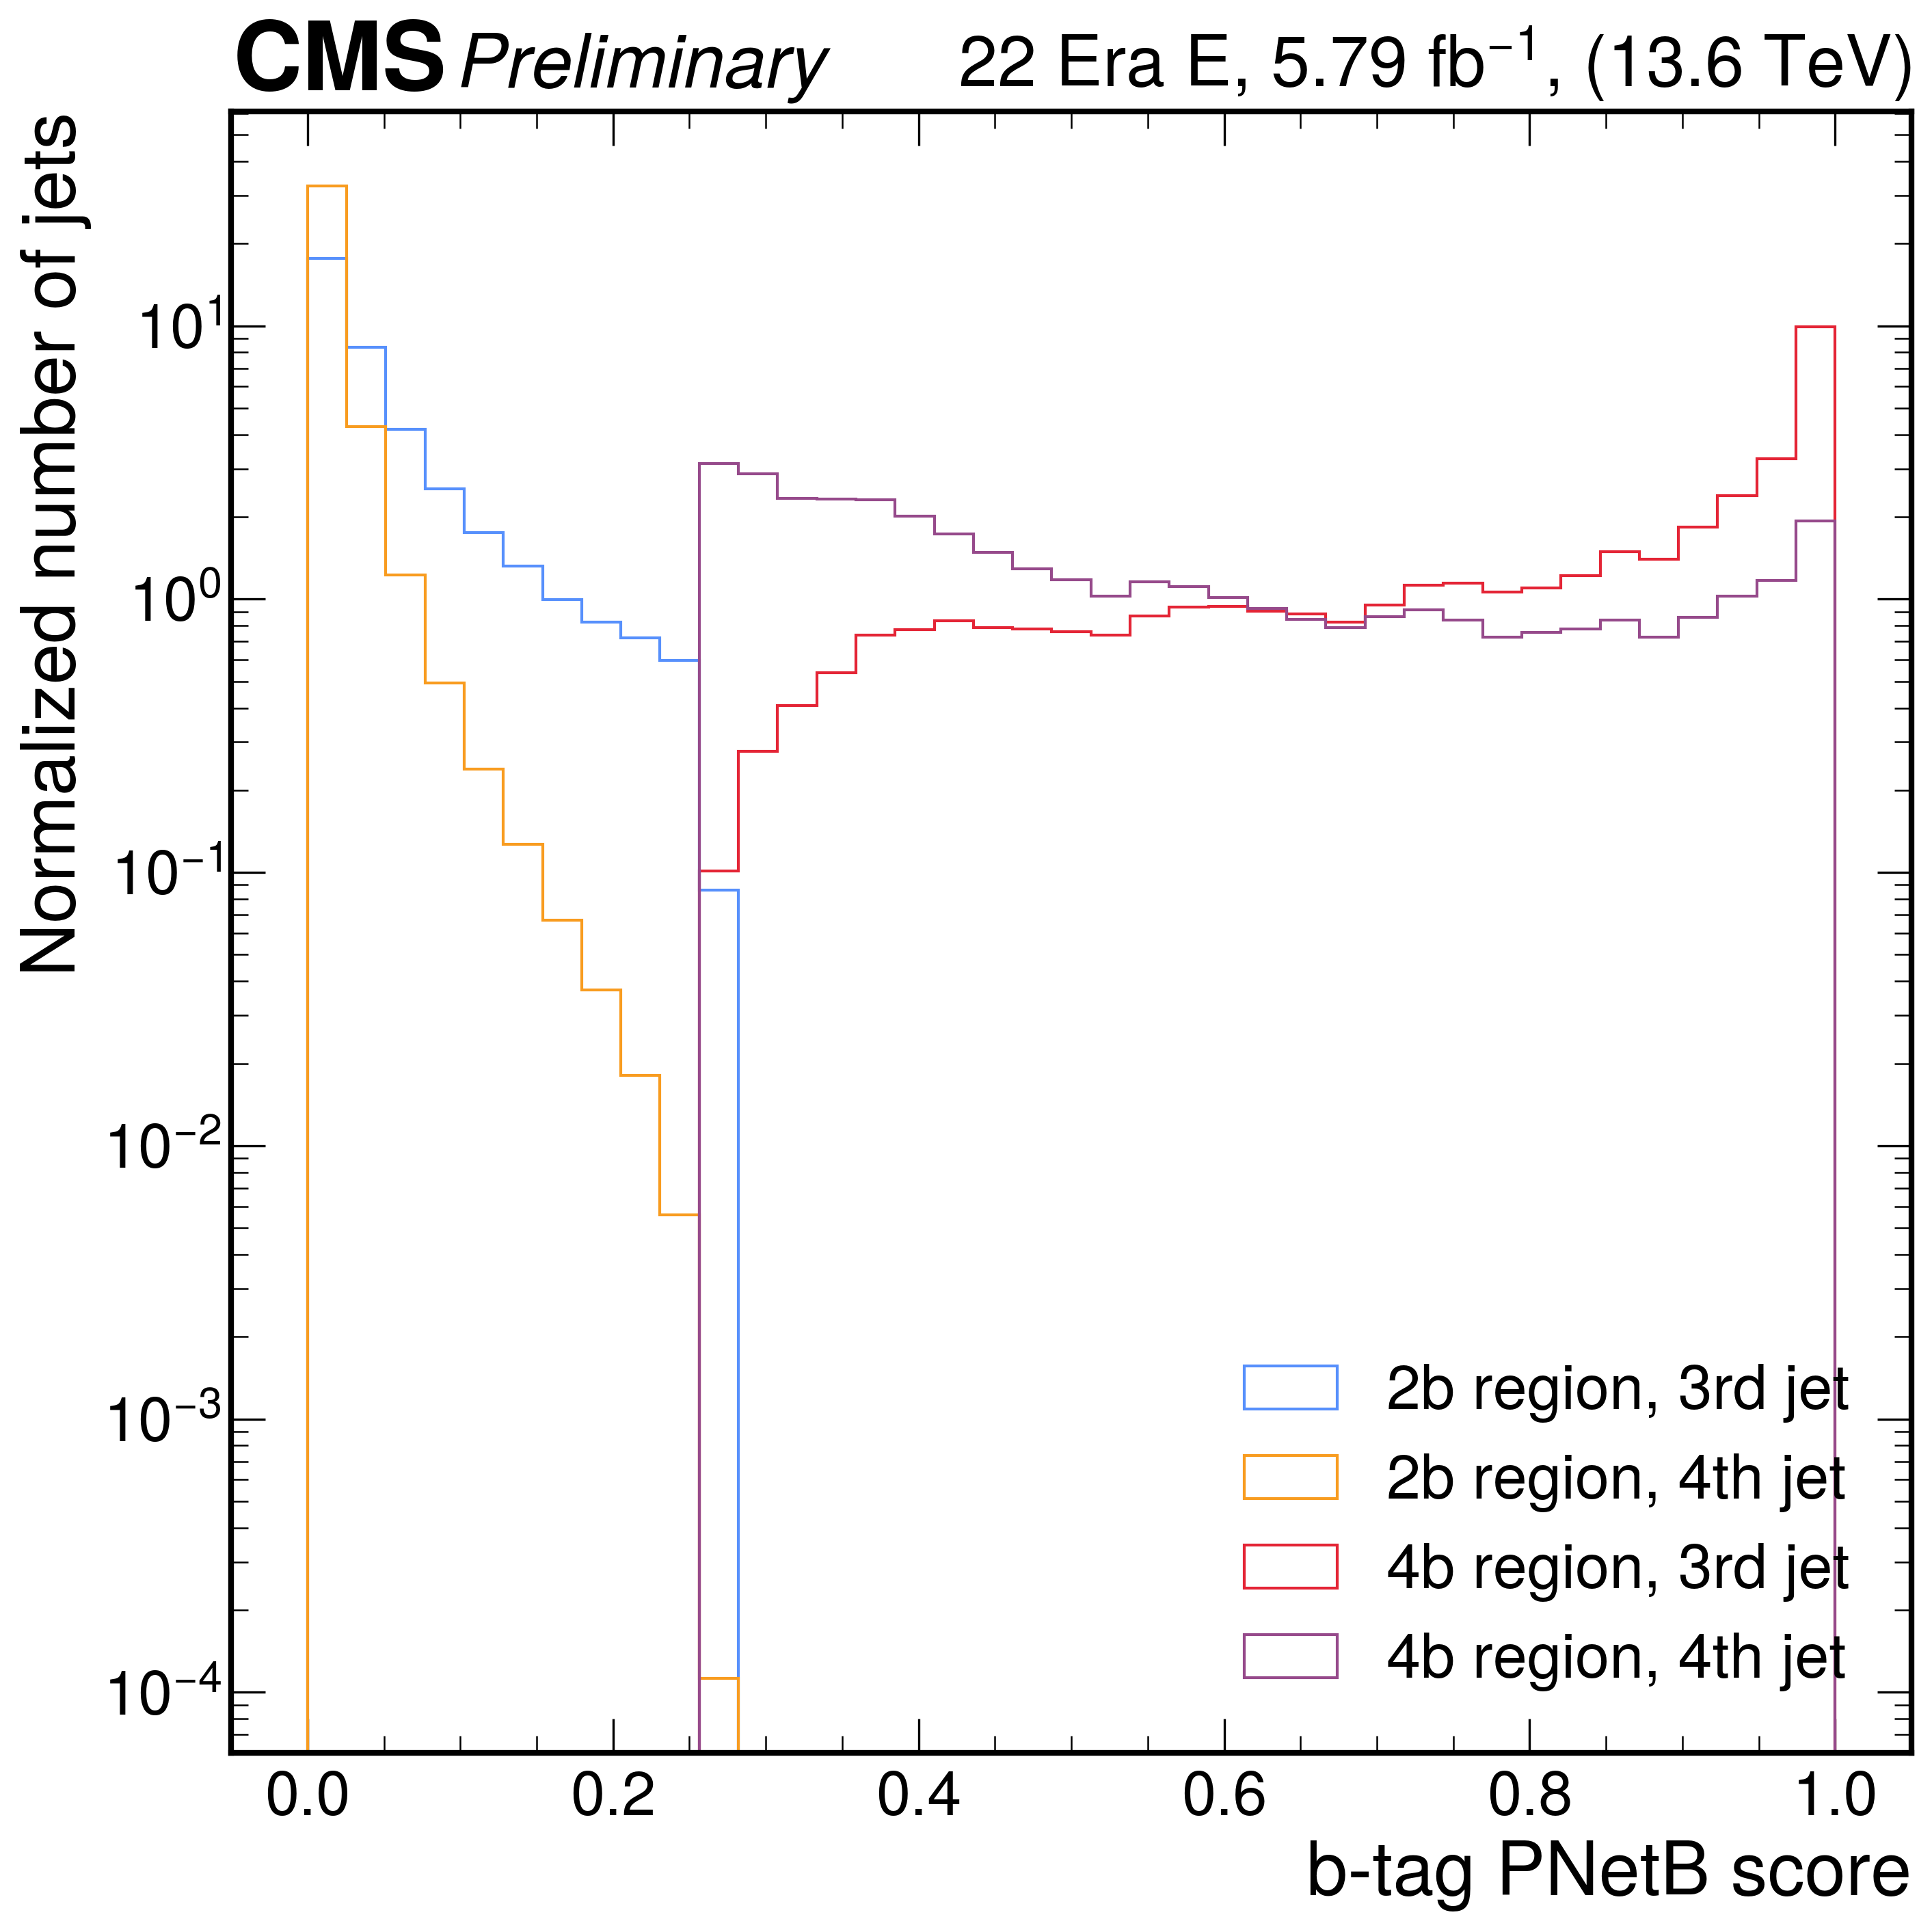

In [18]:
# plot btag distributions
# plt.style.use(hep.style.CMS)
fig, ax=plt.subplots()
plt.hist(jet_btag_3_2b, bins=np.linspace(0, 1, 40), histtype="step", label="2b region, 3rd jet", density=True)#, color="blue")
plt.hist(jet_btag_4_2b, bins=np.linspace(0, 1, 40), histtype="step", label="2b region, 4th jet", density=True)#, color="orange")
plt.hist(jet_btag_3_4b, bins=np.linspace(0, 1, 40), histtype="step", label="4b region, 3rd jet", density=True)#, color="green")
plt.hist(jet_btag_4_4b, bins=np.linspace(0, 1, 40), histtype="step", label="4b region, 4th jet", density=True)#, color="red")
plt.xlabel("b-tag PNetB score")
plt.ylabel("Normalized number of jets")
plt.yscale("log")
plt.legend()
hep.cms.text(text="Preliminary")
hep.cms.lumitext(
    f"22 Era E, 5.79" + r" $fb^{-1}$, (13.6 TeV)",
    ax=ax,
)
# plt.title("b-tag PNetB score for 2b and 4b regions")
plt.tight_layout()
plt.show()


ROC AUC for 2b vs 4b: 0.766


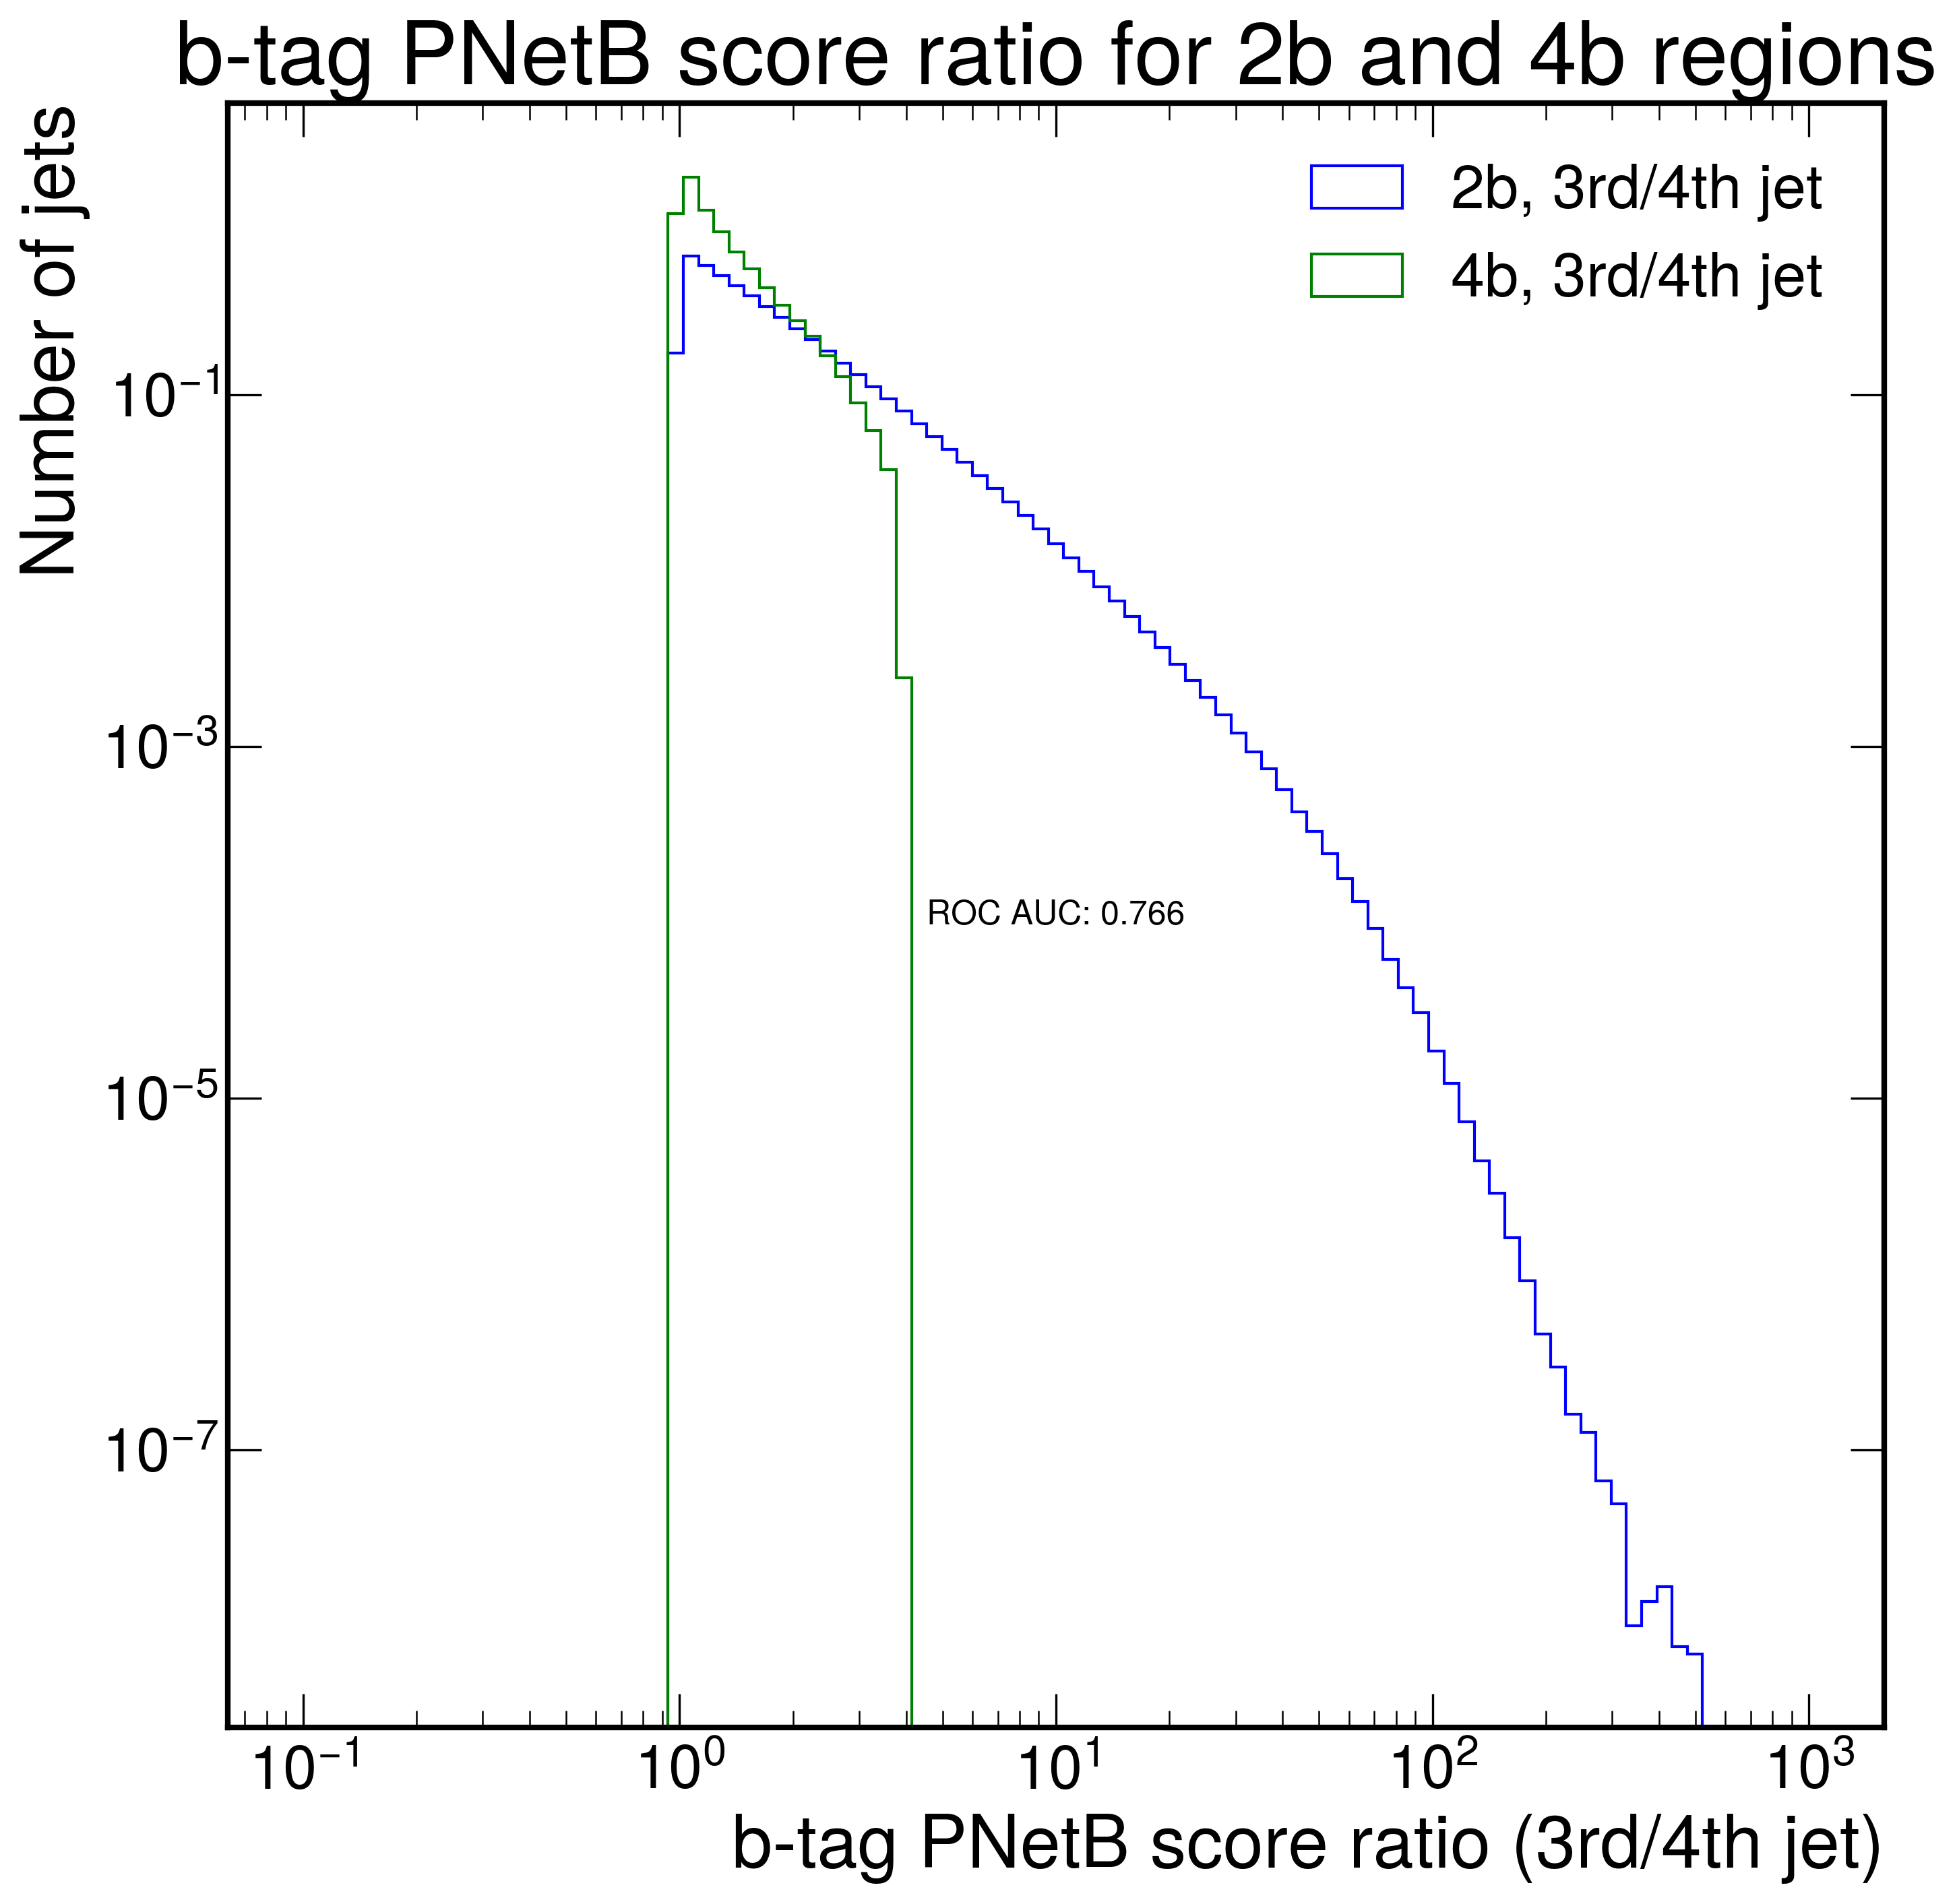

In [11]:
jet_btag_3o4_2b = jet_btag_3_2b/ jet_btag_4_2b
jet_btag_3o4_4b = jet_btag_3_4b/ jet_btag_4_4b
# plot btag ratio distributions
plt.figure()
bins_2b=np.logspace(-1, 3, 100)
plt.hist(jet_btag_3o4_2b, bins=bins_2b, histtype="step", label="2b, 3rd/4th jet", color="blue", density=True)
plt.hist(jet_btag_3o4_4b, bins=bins_2b, histtype="step", label="4b, 3rd/4th jet", color="green", density=True)
plt.xlabel("b-tag PNetB score ratio (3rd/4th jet)")
plt.ylabel("Number of jets")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title("b-tag PNetB score ratio for 2b and 4b regions")
plt.tight_layout()

# calculate ROC AUC
auc_2o4 = roc_auc_score(
    np.concatenate([np.ones_like(jet_btag_3o4_2b), np.zeros_like(jet_btag_3o4_4b)]),
    np.concatenate([jet_btag_3o4_2b, jet_btag_3o4_4b])
)
print(f"ROC AUC for 2b vs 4b: {auc_2o4:.3f}")
plt.text(0.5, 0.5, f"ROC AUC: {auc_2o4:.3f}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)                        
plt.show()

[<Array [0.41, 0.224, 0.575, ... 0.268, 0.0237] type='6250987 * float32'>, <Array [0.521, 0.52, 0.899, ... 0.86, 0.78] type='135936 * float32'>]
AUC for 2b vs 4b (3rd jet): 0.7657550236


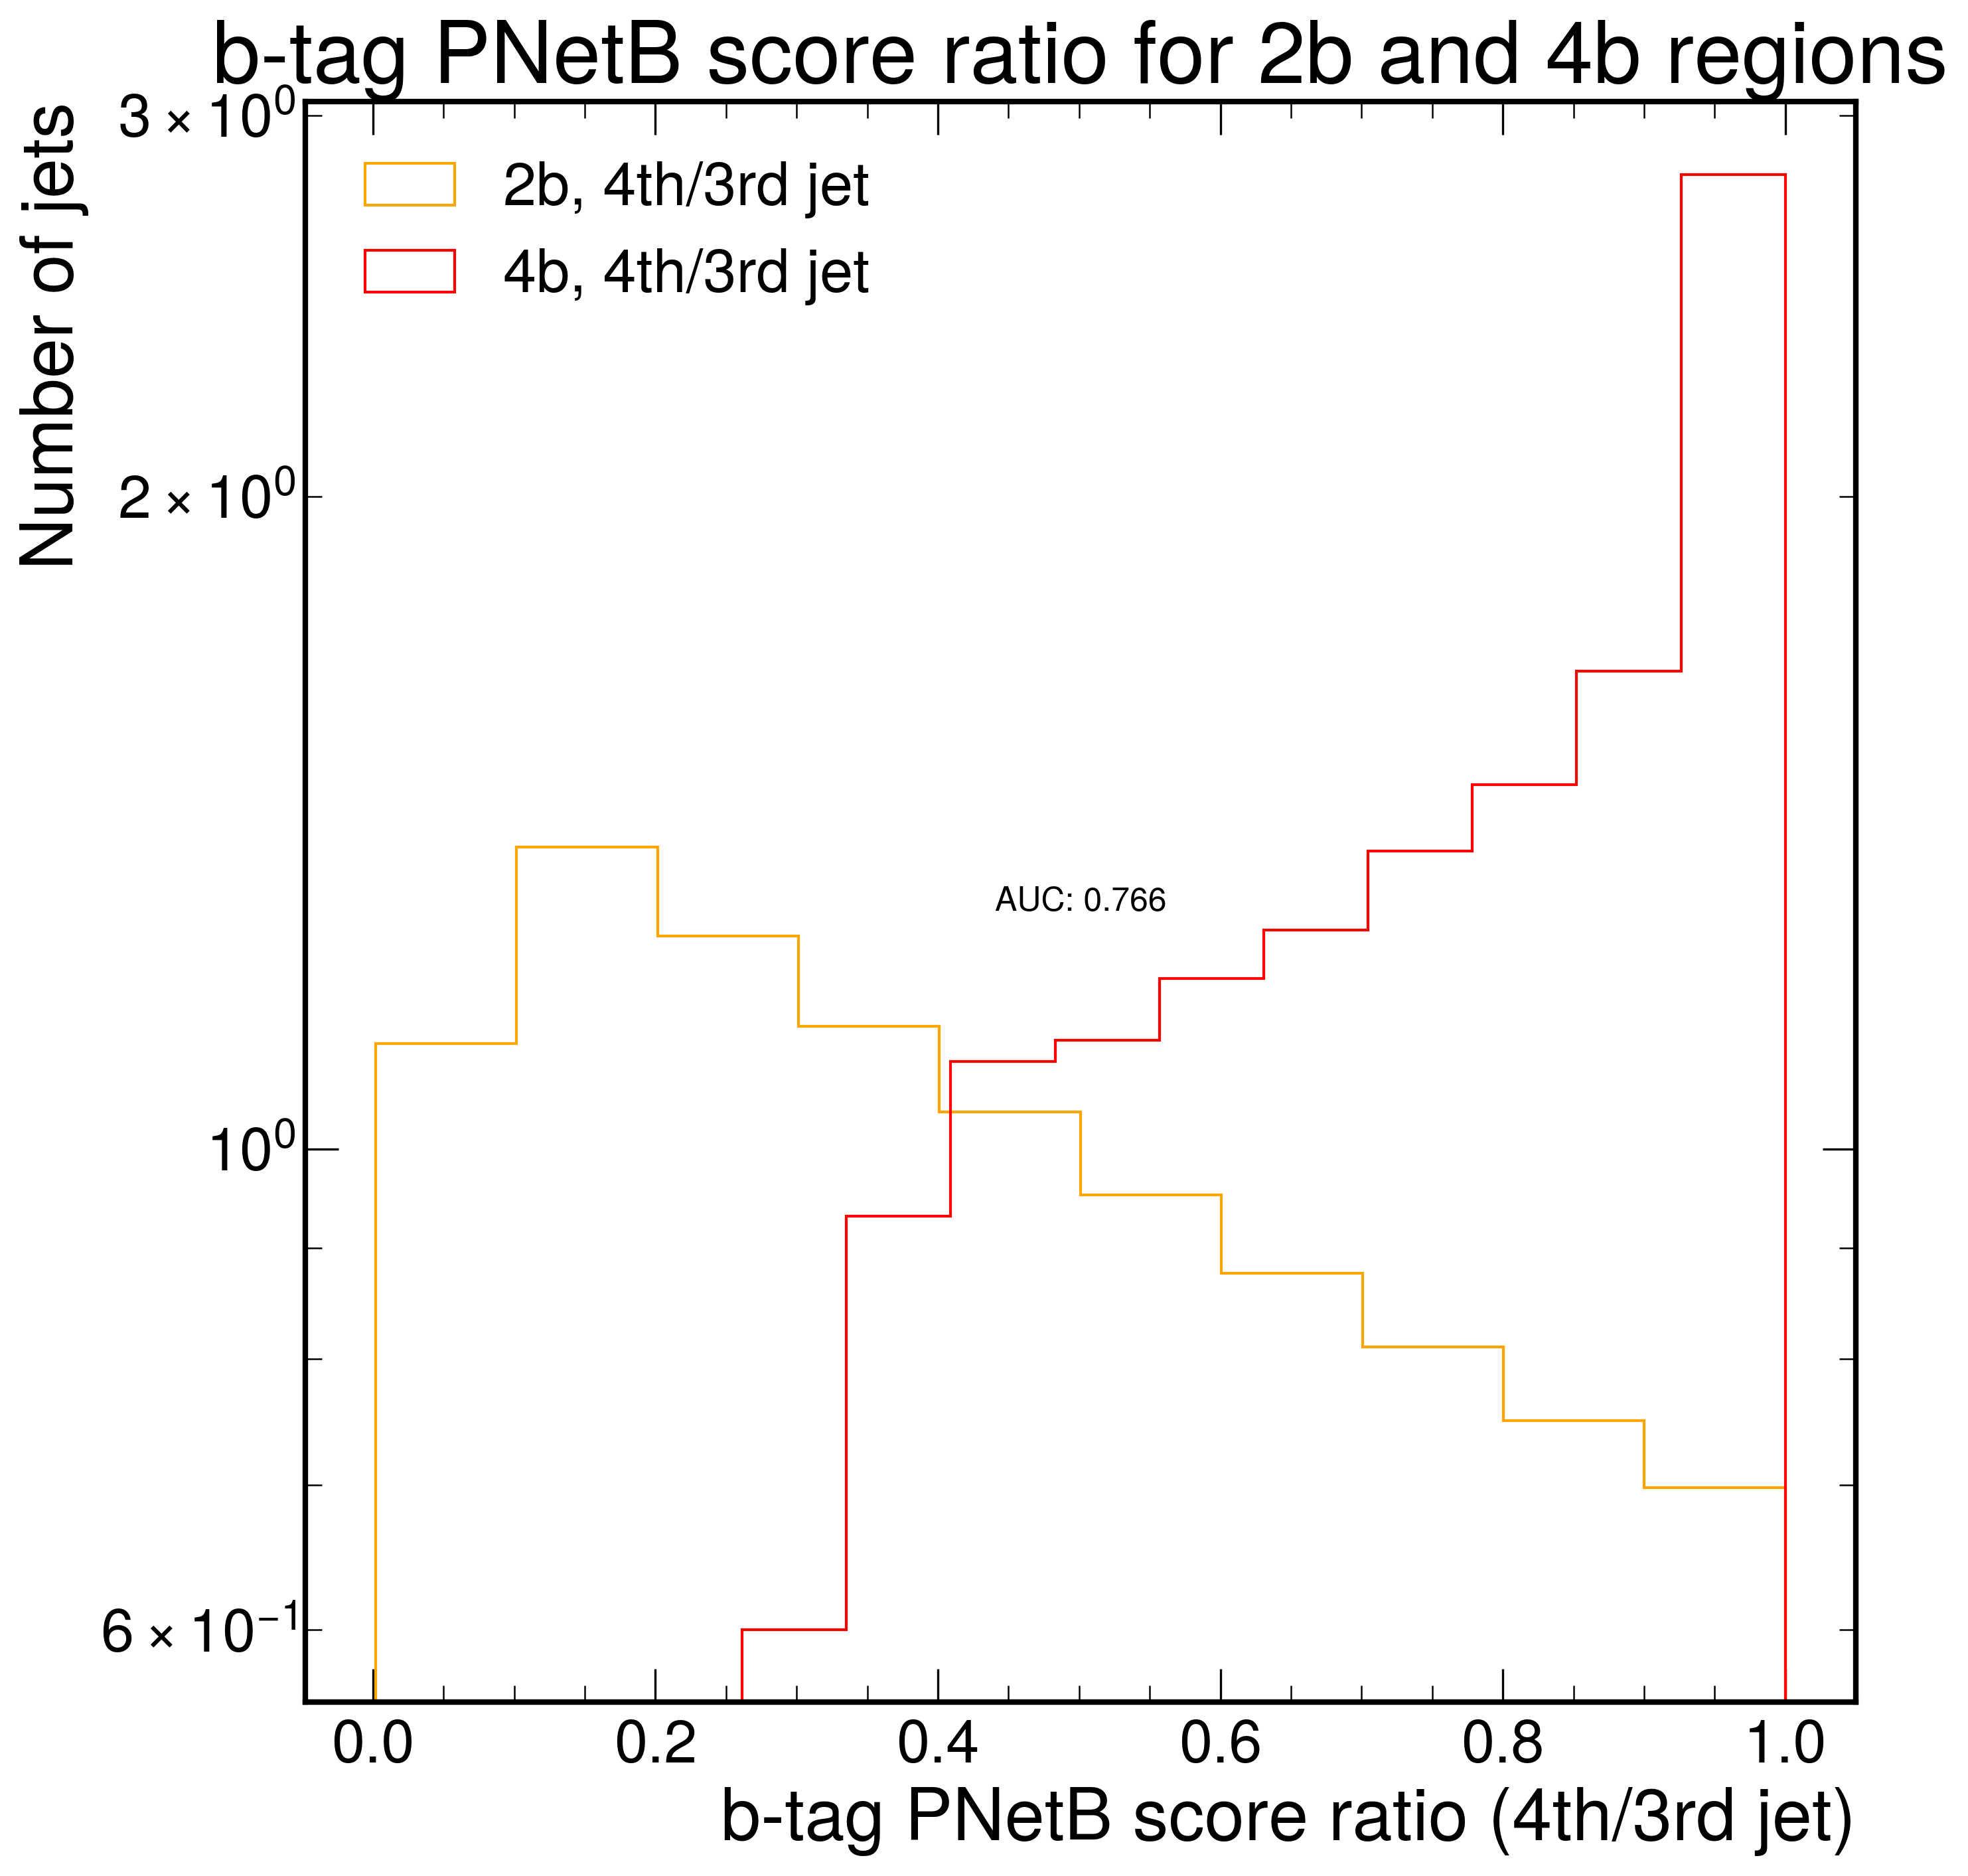

In [12]:
jet_btag_4o3_2b = jet_btag_4_2b/ jet_btag_3_2b
jet_btag_4o3_4b = jet_btag_4_4b/ jet_btag_3_4b
# plot btag ratio distributions
plt.figure()
plt.hist(jet_btag_4o3_2b, histtype="step", label="2b, 4th/3rd jet", color="orange", density=True)
plt.hist(jet_btag_4o3_4b, histtype="step", label="4b, 4th/3rd jet", color="red", density=True)
plt.xlabel("b-tag PNetB score ratio (4th/3rd jet)")
plt.ylabel("Number of jets")
plt.yscale("log")
plt.legend()
plt.title("b-tag PNetB score ratio for 2b and 4b regions")
plt.tight_layout()

#compute the auc of the roc of 2b vs 4b
auc_4o3 = roc_auc_score(np.concatenate([np.zeros(len(jet_btag_3_2b)), np.ones(len(jet_btag_3_4b))]),
                          np.concatenate([jet_btag_4o3_2b, jet_btag_4o3_4b]))
print([jet_btag_4o3_2b, jet_btag_4o3_4b])
print(f"AUC for 2b vs 4b (3rd jet): {auc_4o3:.10f}")
plt.text(0.5, 0.5, f"AUC: {auc_4o3:.3f}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()




[<Array [0.291, 0.183, 0.365, ... 0.211, 0.0231] type='6250987 * float32'>, <Array [0.343, 0.342, 0.473, ... 0.462, 0.438] type='135936 * float32'>]
AUC for 2b vs 4b (3rd/(3rd+4th) jet): 0.7657550236


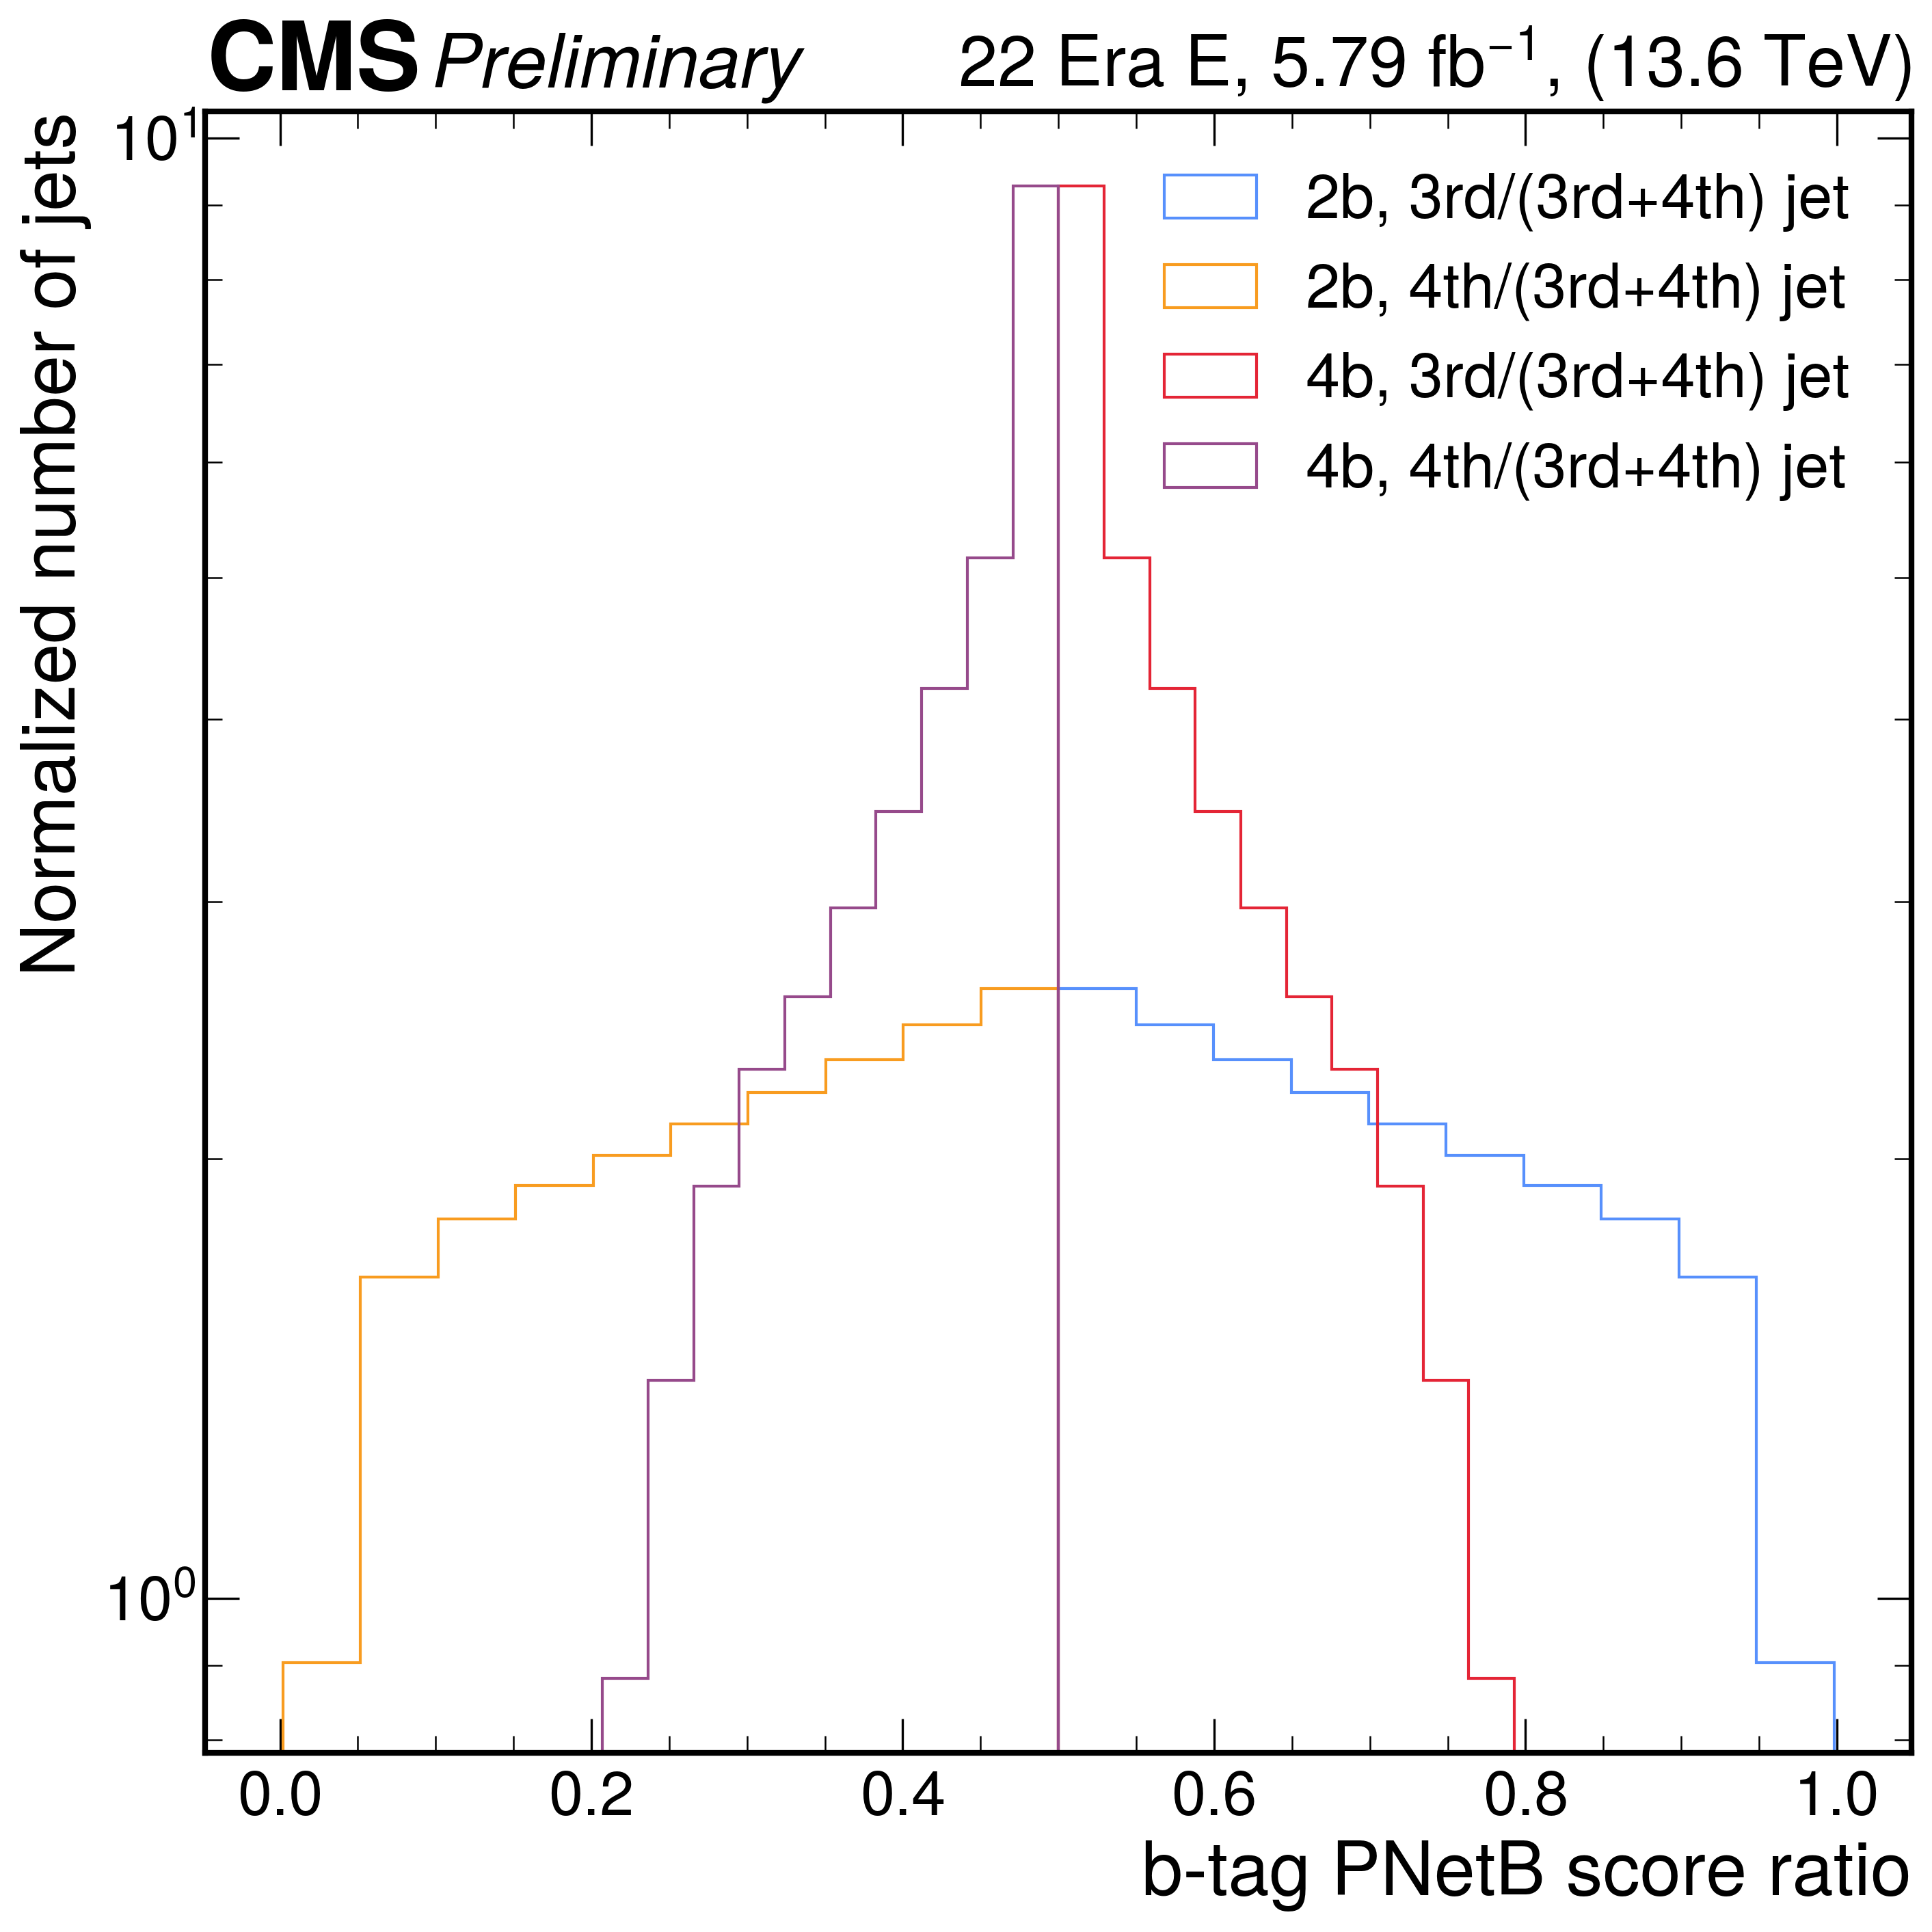

In [20]:
jet_btag_3o3p4_2b= jet_btag_3_2b/ (jet_btag_3_2b + jet_btag_4_2b)
jet_btag_4o3p4_2b= jet_btag_4_2b/ (jet_btag_3_2b + jet_btag_4_2b)

jet_btag_3o3p4_4b= jet_btag_3_4b/ (jet_btag_3_4b + jet_btag_4_4b)
jet_btag_4o3p4_4b= jet_btag_4_4b/ (jet_btag_3_4b + jet_btag_4_4b)

# plot btag ratio distributions
fig, ax=plt.subplots()
plt.hist(jet_btag_3o3p4_2b, histtype="step", label="2b, 3rd/(3rd+4th) jet", density=True)#, color="blue")
plt.hist(jet_btag_4o3p4_2b, histtype="step", label="2b, 4th/(3rd+4th) jet", density=True)#, color="orange")
plt.hist(jet_btag_3o3p4_4b, histtype="step", label="4b, 3rd/(3rd+4th) jet", density=True)#, color="green")
plt.hist(jet_btag_4o3p4_4b, histtype="step", label="4b, 4th/(3rd+4th) jet", density=True)#, color="red")
plt.xlabel("b-tag PNetB score ratio")
plt.ylabel("Normalized number of jets")
plt.yscale("log")
plt.legend()
# plt.title("b-tag PNetB score ratio for 2b and 4b regions")
hep.cms.text(text="Preliminary")
hep.cms.lumitext(
    f"22 Era E, 5.79" + r" $fb^{-1}$, (13.6 TeV)",
    ax=ax,
)

plt.tight_layout()

# compute the auc of the roc of 2b vs 4b
auc_4o3p4 = roc_auc_score(np.concatenate([np.zeros(len(jet_btag_4o3p4_2b)), np.ones(len(jet_btag_4o3p4_4b))]),
                          np.concatenate([jet_btag_4o3p4_2b, jet_btag_4o3p4_4b]))
print([jet_btag_4o3p4_2b, jet_btag_4o3p4_4b])
print(f"AUC for 2b vs 4b (3rd/(3rd+4th) jet): {auc_4o3p4:.10f}")
# plt.text(0.5, 0.5, f"AUC: {auc_4o3p4:.3f}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()



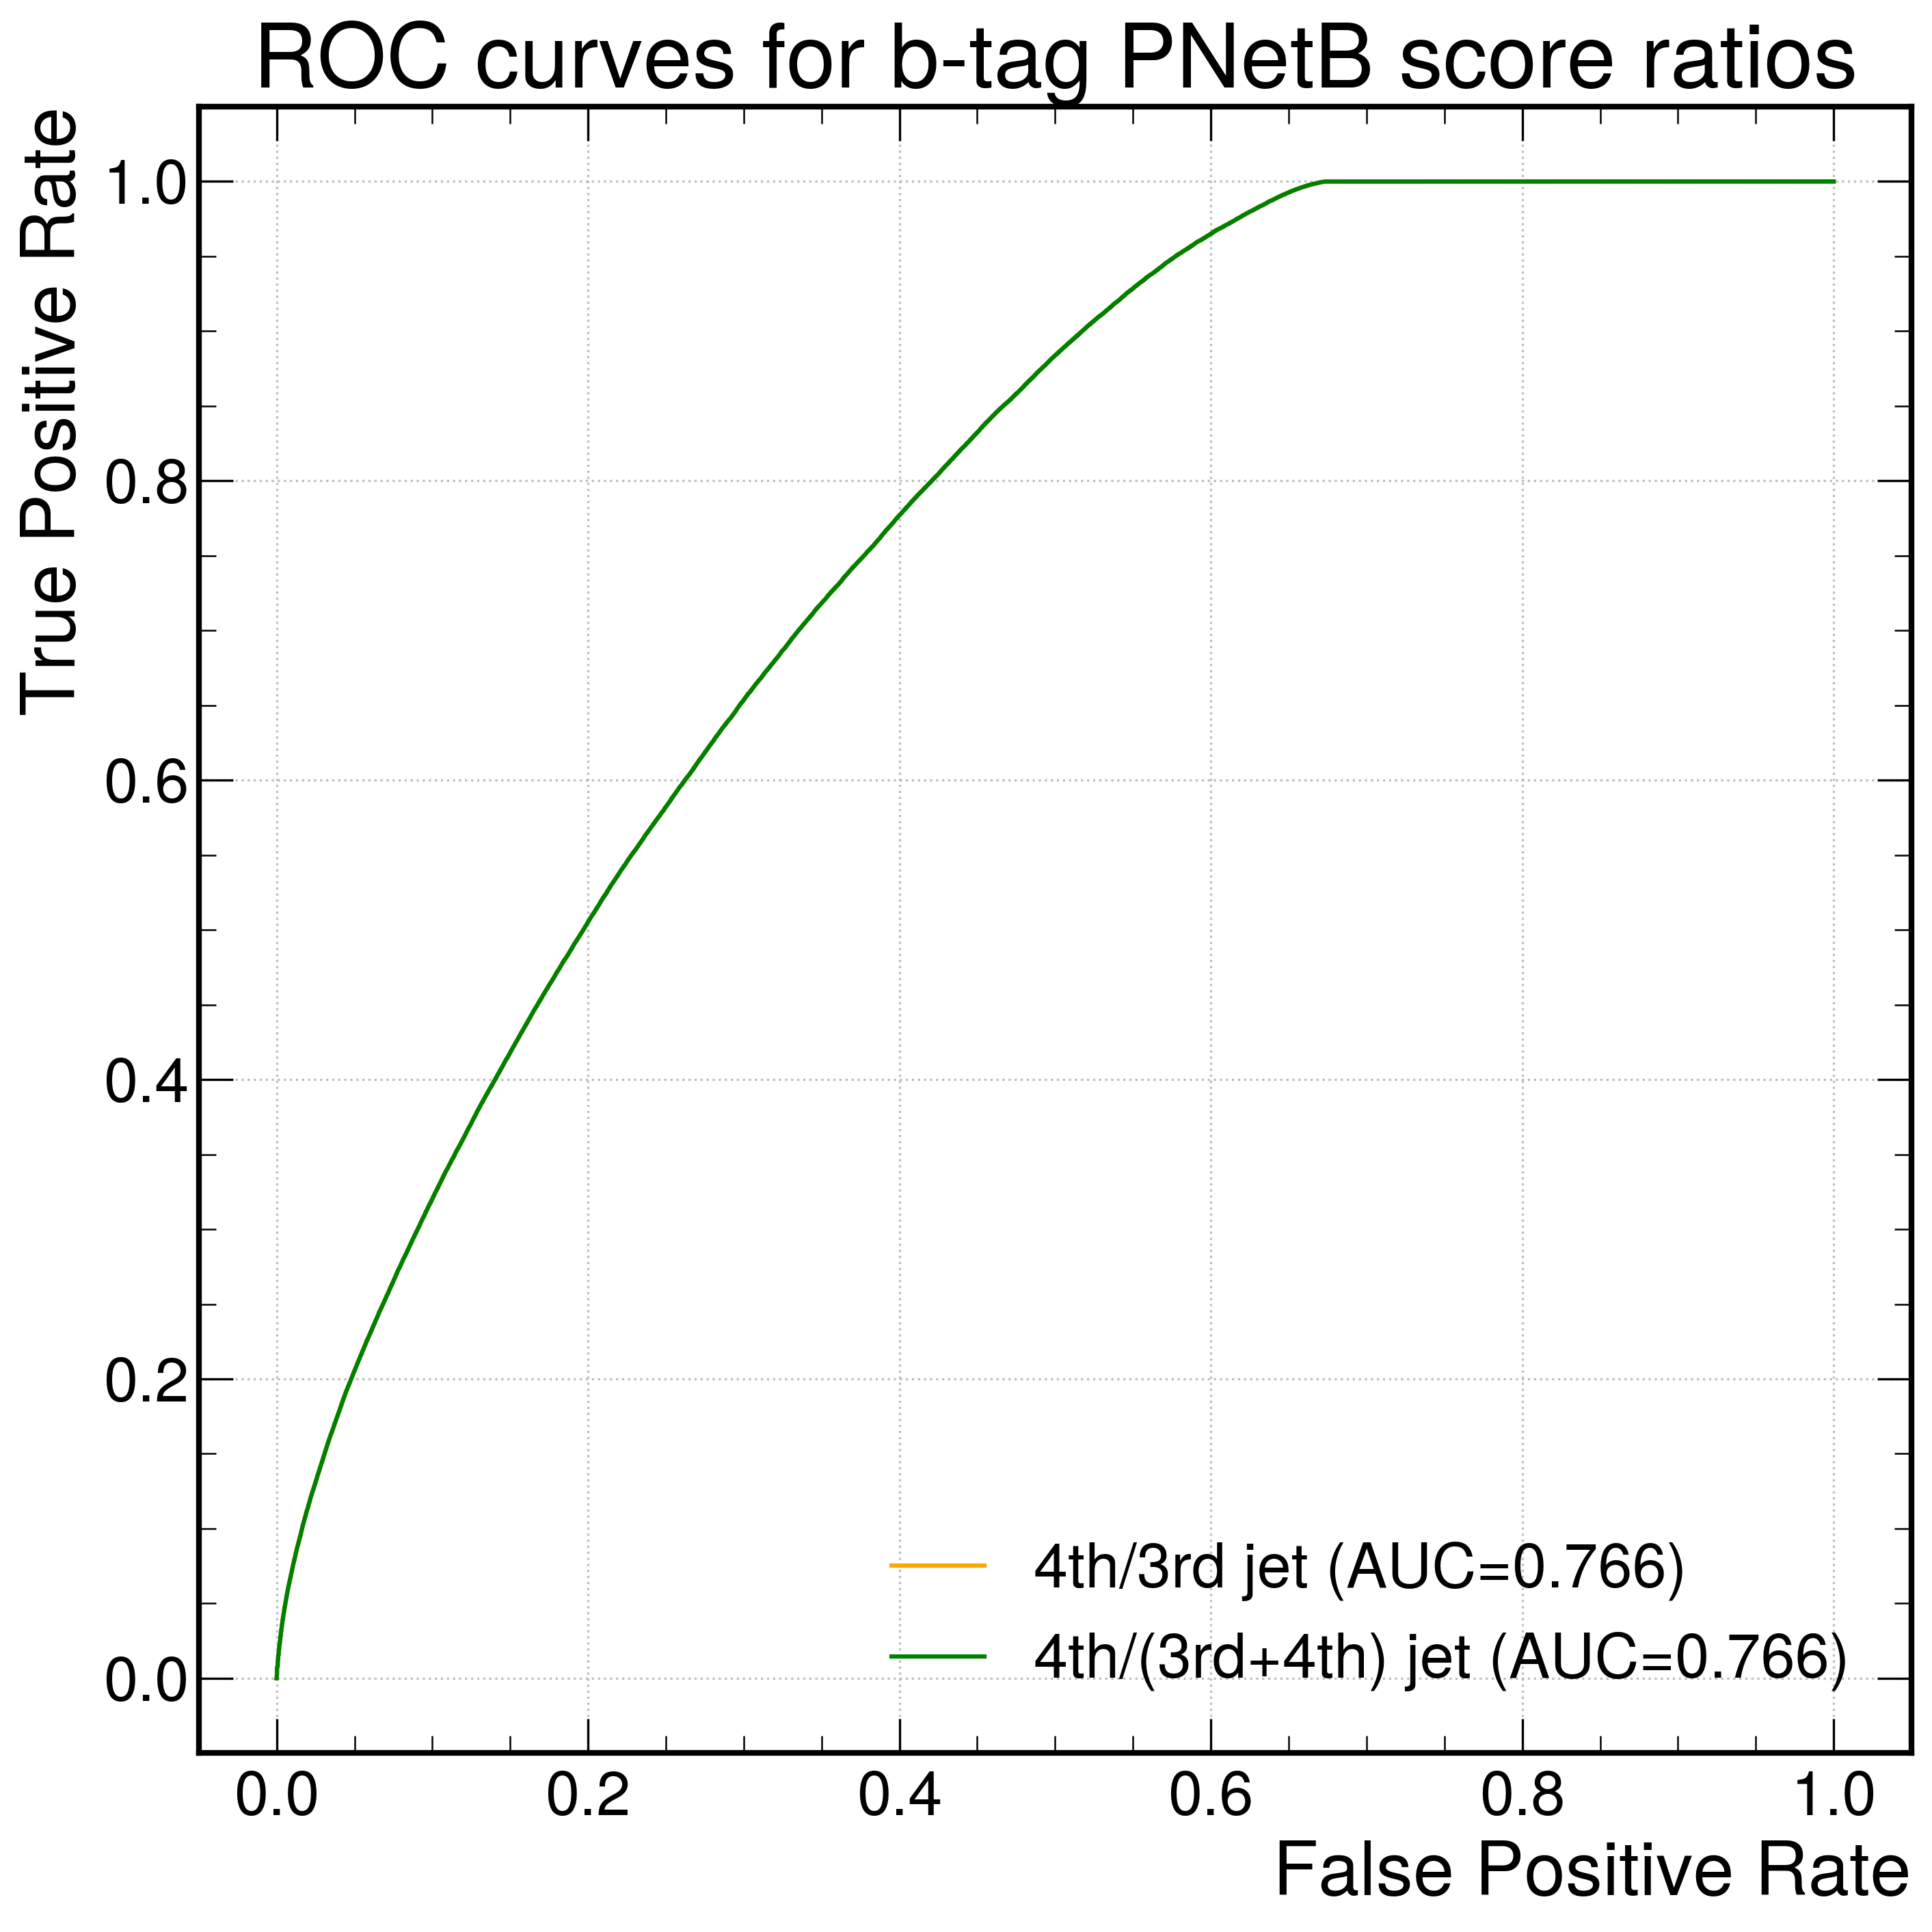

In [14]:
# plot the 3 ROC curves 
plt.figure()
fpr_3o4, tpr_3o4, _ = roc_curve(
    np.concatenate([np.ones_like(jet_btag_3o4_2b), np.zeros_like(jet_btag_3o4_4b)]),
    np.concatenate([jet_btag_3o4_2b, jet_btag_3o4_4b])
)
# plt.plot(fpr_3o4, tpr_3o4, label=f"3rd/4th jet (AUC={auc_2o4:.3f})", color="blue")
fpr_4o3, tpr_4o3, _ = roc_curve(
    np.concatenate([np.zeros(len(jet_btag_3_2b)), np.ones(len(jet_btag_3_4b))]),
    np.concatenate([jet_btag_4o3_2b, jet_btag_4o3_4b])
)
plt.plot(fpr_4o3, tpr_4o3, label=f"4th/3rd jet (AUC={auc_4o3:.3f})", color="orange")
fpr_4o3p4, tpr_4o3p4, _ = roc_curve(
    np.concatenate([np.zeros(len(jet_btag_4o3p4_2b)), np.ones(len(jet_btag_4o3p4_4b))]),
    np.concatenate([jet_btag_4o3p4_2b, jet_btag_4o3p4_4b])
)
plt.plot(fpr_4o3p4, tpr_4o3p4, label=f"4th/(3rd+4th) jet (AUC={auc_4o3p4:.3f})", color="green")





plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for b-tag PNetB score ratios")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



In [15]:
print(fpr_3o4, tpr_3o4)
print(fpr_4o3, tpr_4o3)
print(fpr_4o3p4, tpr_4o3p4)

for i in range(100):
    print(f"3o4: {fpr_3o4[i]:.4f}, {tpr_3o4[i]:.4f}")
for i in range(100):
    print(f"4o3: {fpr_4o3[i]:.4f}, {tpr_4o3[i]:.4f}")
for i in range(100):
    print(f"4o3p4: {fpr_4o3p4[i]:.4f}, {tpr_4o3p4[i]:.4f}")    

[0.         0.         0.         ... 0.99722664 0.99722664 1.        ] [0.00000000e+00 1.59974737e-07 7.95074442e-05 ... 9.99768517e-01
 9.99768837e-01 1.00000000e+00]
[0.00000000e+00 2.31163495e-04 2.31483444e-04 ... 9.99920173e-01
 9.99920493e-01 1.00000000e+00] [0.         0.00277336 0.00277336 ... 1.         1.         1.        ]
[0.00000000e+00 2.31163495e-04 2.31483444e-04 ... 9.99920173e-01
 9.99920493e-01 1.00000000e+00] [0.         0.00277336 0.00277336 ... 1.         1.         1.        ]
3o4: 0.0000, 0.0000
3o4: 0.0000, 0.0000
3o4: 0.0000, 0.0001
3o4: 0.0000, 0.0001
3o4: 0.0000, 0.0001
3o4: 0.0000, 0.0001
3o4: 0.0000, 0.0002
3o4: 0.0000, 0.0002
3o4: 0.0000, 0.0002
3o4: 0.0000, 0.0002
3o4: 0.0000, 0.0002
3o4: 0.0000, 0.0002
3o4: 0.0000, 0.0002
3o4: 0.0000, 0.0002
3o4: 0.0000, 0.0002
3o4: 0.0000, 0.0002
3o4: 0.0000, 0.0002
3o4: 0.0000, 0.0002
3o4: 0.0000, 0.0002
3o4: 0.0000, 0.0002
3o4: 0.0000, 0.0003
3o4: 0.0000, 0.0003
3o4: 0.0000, 0.0003
3o4: 0.0000, 0.0003
3o4: 0.0000, 

In [16]:
random_array_1 = np.random.rand(len(jet_btag_3o4_2b) )
random_array_2 = np.random.rand(len(jet_btag_3o4_4b) )


fpr_4o3p4_1, tpr_4o3p4_1, _ = roc_curve(
    np.concatenate([np.zeros(len(jet_btag_4o3p4_2b)), np.ones(len(jet_btag_4o3p4_4b))]),
    np.concatenate([jet_btag_4o3p4_2b*random_array_1, jet_btag_4o3p4_4b*random_array_2])
)
auc_4o3p4_1= roc_auc_score(np.concatenate([np.zeros(len(jet_btag_4o3p4_2b)), np.ones(len(jet_btag_4o3p4_4b))]),
                          np.concatenate([jet_btag_4o3p4_2b*random_array_1, jet_btag_4o3p4_4b*random_array_2]))



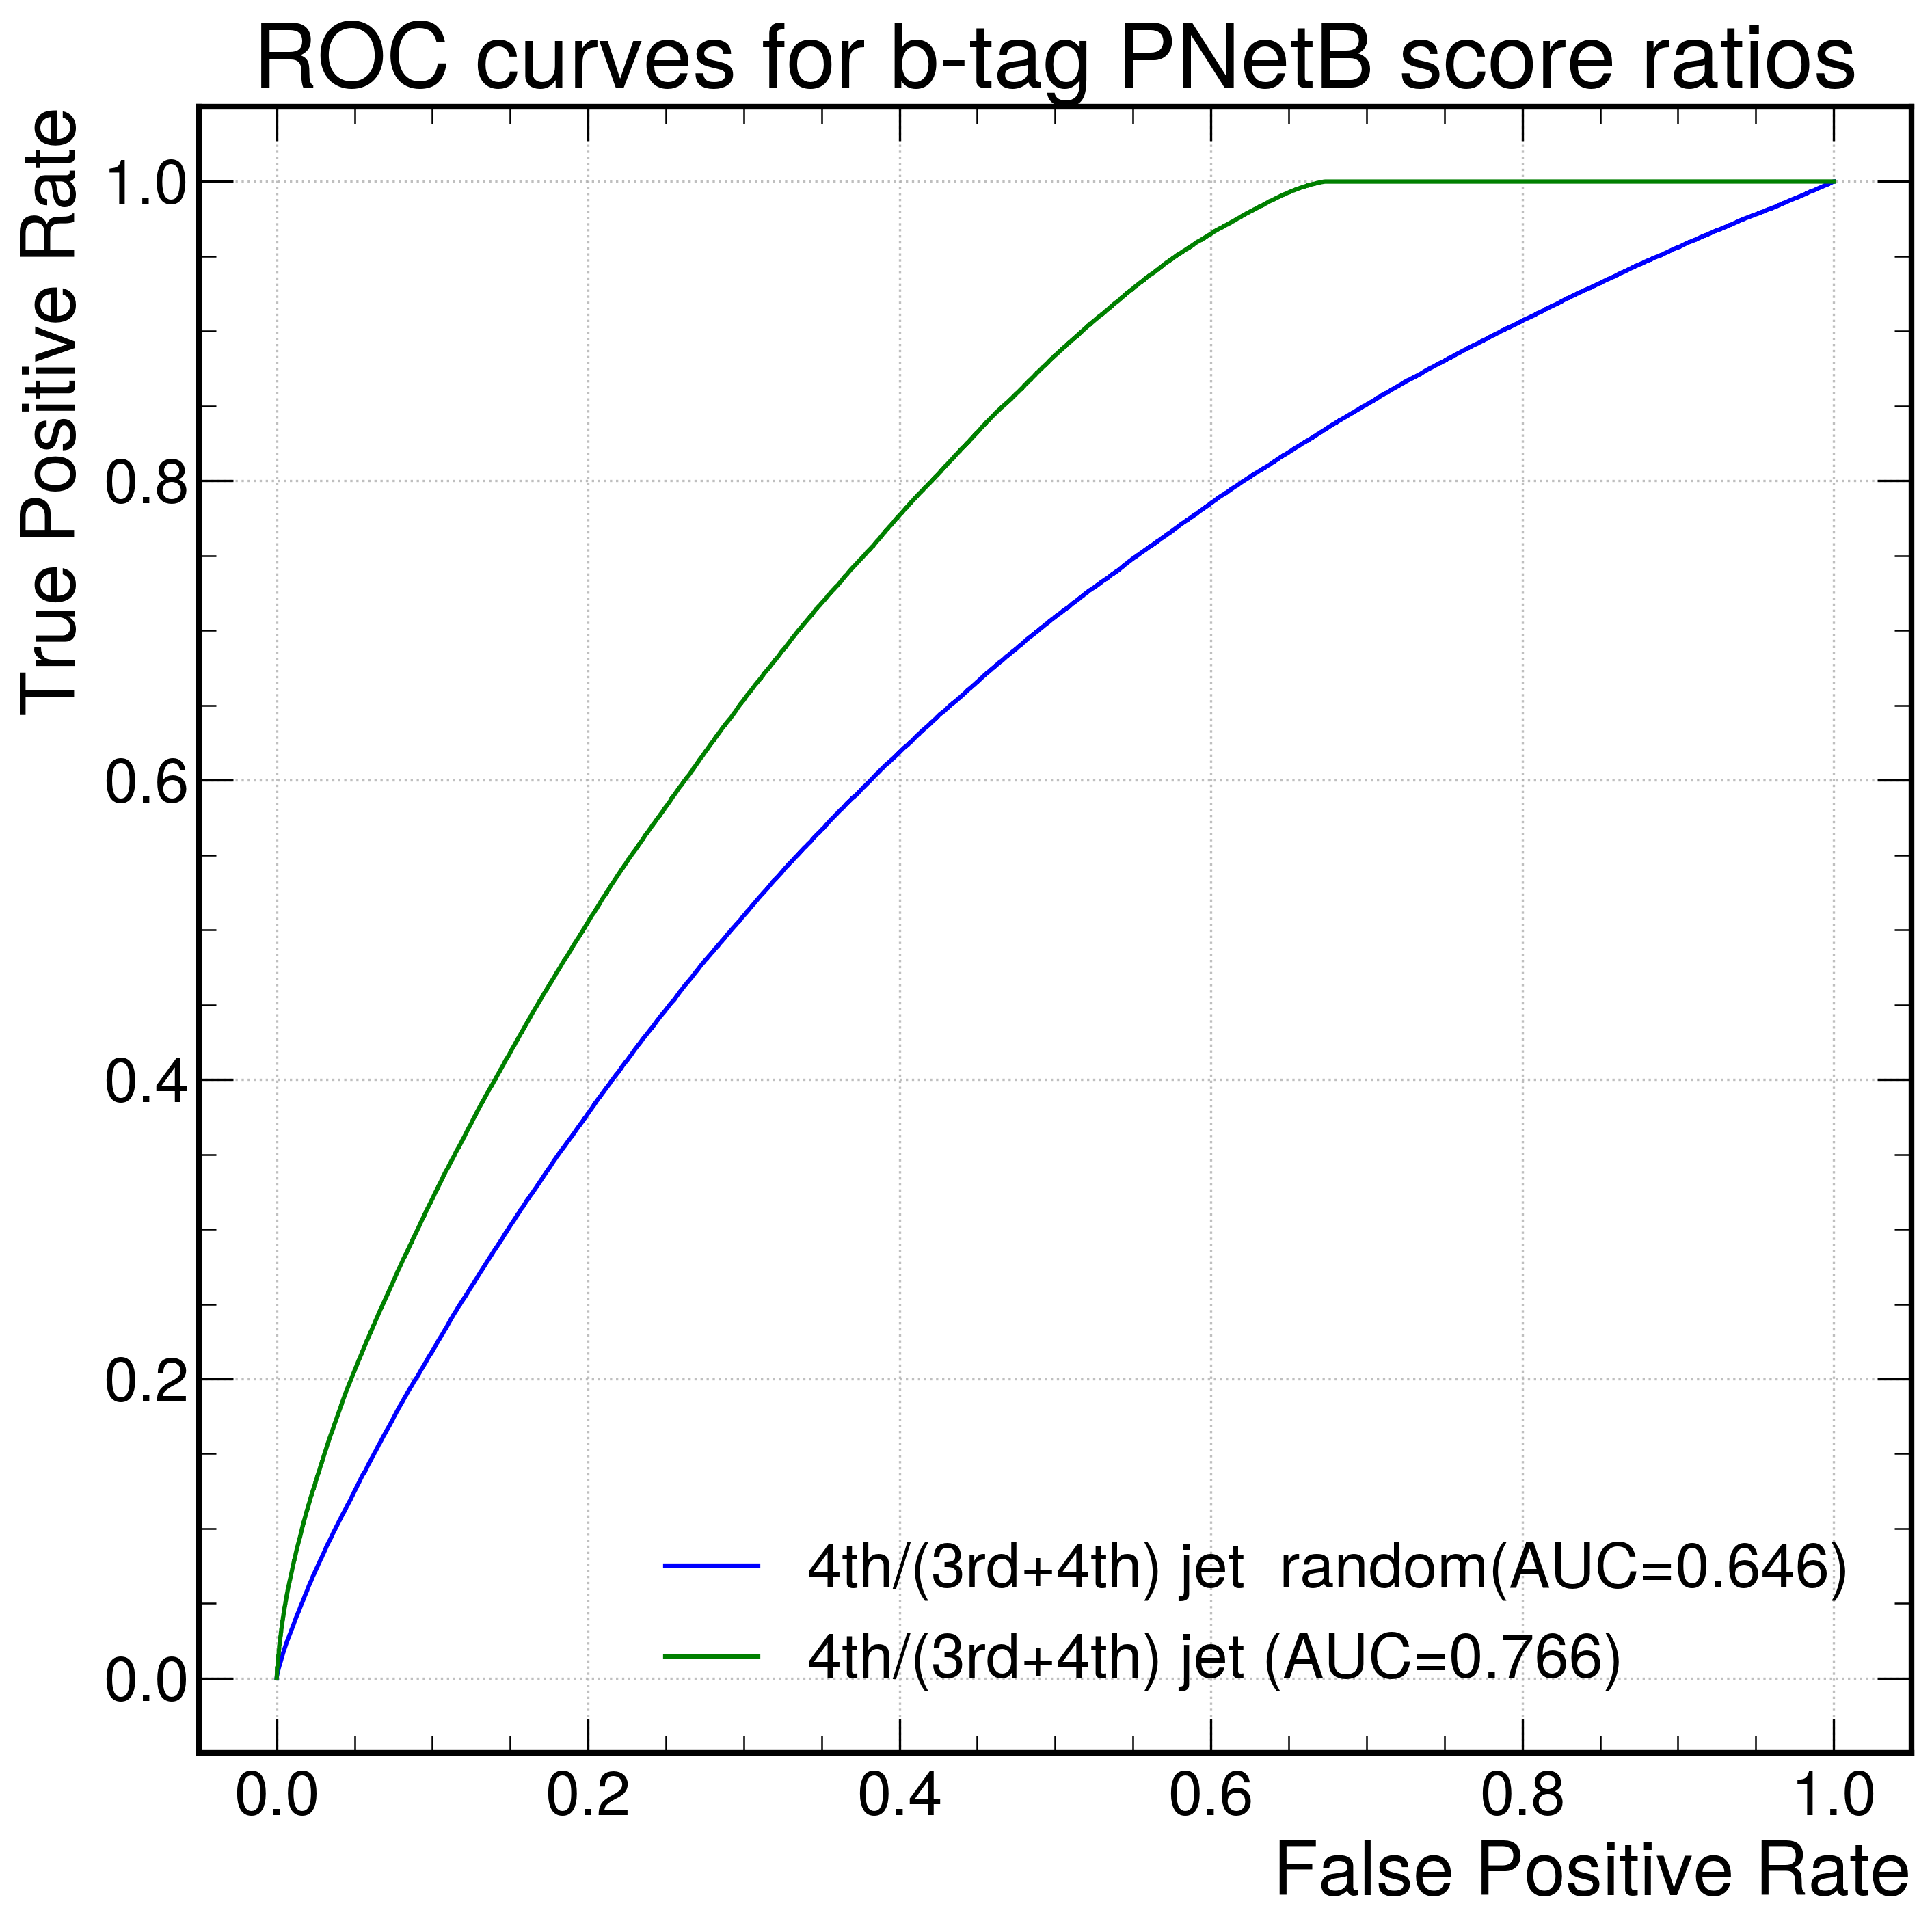

In [17]:
plt.figure()
plt.plot(fpr_4o3p4_1, tpr_4o3p4_1, label=f"4th/(3rd+4th) jet  random(AUC={auc_4o3p4_1:.3f})", color="blue")
plt.plot(fpr_4o3p4, tpr_4o3p4, label=f"4th/(3rd+4th) jet (AUC={auc_4o3p4:.3f})", color="green")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for b-tag PNetB score ratios")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()